We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following notebook we compute the Finite Time Lyapunov Exponent ($ \mathrm{FTLE} $) on the three-dimensional, steady ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'ABCsteady.mat' stored in the folder 'data/ABC'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{FTLE} $:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
     <br />
    * Compute $ \mathrm{FTLE} $ from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0))
    \end{equation}
 <br />
6. References

# Import data

We start by importing the ABC-data from 'ABCsteady.mat' located in the folder 'data/ABC'.

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ))

# Computational parameters

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = False # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [13]:
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 10 # float

# Time step-size (in days)
dt = 0.1 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]
dz = z_domain[1]-z_domain[0]

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

# auxiliary grid spacing
aux_grid = [0.1*dx, 0.1*dy, 0.1*dz] # list (3,)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

x_domain_poincare = np.linspace(xmin, xmax, 10, endpoint = True) # array (20, )
y_domain_poincare = np.linspace(ymin, ymax, 10, endpoint = True) # array (20, )
z_domain_poincare = np.linspace(zmin, zmax, 10, endpoint = True) # array (20, )

X_domain_poincare, Y_domain_poincare, Z_domain_poincare = np.meshgrid(x_domain_poincare, y_domain_poincare, z_domain_poincare) # array (10, 10, 10) 

# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [14]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# Compute gradient of flow map

In [15]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def calculate_gradFmap(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch]) # array (3, Nx*Ny*Nz)

    DF = gradient_flowmap(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid)[1] # array (Nt, 3, 3, Nx*Ny*Nz)
    
    return DF[-1,:,:,:]

In [ ]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0 = X_domain.ravel() # array (Nx*Ny*Nz,)
y0 = Y_domain.ravel() # array (Nx*Ny*Nz,)
z0 = Z_domain.ravel() # array (Nx*Ny*Nz,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny)

results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(calculate_gradFmap)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract gradient of flow map from results of parallel computing
gradFmap = results[0]

for res in results[1:]:
    gradFmap = np.append(gradFmap, res, axis = 2)
    
# Reshape array storing gradient of flow map over meshgrid
gradFmap = np.array(gradFmap).reshape(3, 3, Nx, Ny, Nz)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


# Interpolate gradient of flow map

In [8]:
# Import (cubic) RectangularGridInterpolant from scipy
from scipy.interpolate import RegularGridInterpolator
        
# Compute elements of gradient of flow map
gradF11 = np.nan_to_num(gradFmap[0,0,:,:,:], nan=0.0)
gradF12 = np.nan_to_num(gradFmap[0,1,:,:,:], nan=0.0)
gradF13 = np.nan_to_num(gradFmap[0,2,:,:,:], nan=0.0)

gradF21 = np.nan_to_num(gradFmap[1,0,:,:,:], nan=0.0)
gradF22 = np.nan_to_num(gradFmap[1,1,:,:,:], nan=0.0)
gradF23 = np.nan_to_num(gradFmap[1,2,:,:,:], nan=0.0)

gradF31 = np.nan_to_num(gradFmap[2,0,:,:,:], nan=0.0)
gradF32 = np.nan_to_num(gradFmap[2,1,:,:,:], nan=0.0)
gradF33 = np.nan_to_num(gradFmap[2,2,:,:,:], nan=0.0)

# Interpolate elements of gradient of flow map
interpgradF11 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF11)
interpgradF12 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF12)
interpgradF13 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF13)

interpgradF21 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF21)
interpgradF22 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF22)
interpgradF23 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF23)

interpgradF31 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF31)
interpgradF32 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF32)
interpgradF33 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), gradF33)

def evaluate_gradF(x):
    
    x_flipped = x.copy()
    
    x_flipped.T[[0,1]]= x_flipped.T[[1, 0]]
    
    gradF = np.zeros((x.shape[0], 3, 3))
    gradF[:,0,0] = interpgradF11(x_flipped)
    gradF[:,0,1] = interpgradF12(x_flipped)
    gradF[:,0,2] = interpgradF13(x_flipped)
    
    gradF[:,1,0] = interpgradF21(x_flipped)
    gradF[:,1,1] = interpgradF22(x_flipped)
    gradF[:,1,2] = interpgradF23(x_flipped)

    gradF[:,2,0] = interpgradF31(x_flipped)
    gradF[:,2,1] = interpgradF32(x_flipped)
    gradF[:,2,2] = interpgradF33(x_flipped)
    
    return gradF

In [10]:
# Import package to compute singular values of 3x3 matrix
from ipynb.fs.defs.SVD3D import SVD

def calculate_Fmap(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch]) # array (3, Nx*Ny*Nz)
    
    return evaluate_gradF(X0.transpose())

def oriented_vector(x_interp):
    
    gradFmap_t0_tN = calculate_Fmap(x_interp[:,0], x_interp[:,1], x_interp[:,2])
    
    eigenvector = np.zeros((gradFmap_t0_tN.shape[0], 3))*np.nan
    
    for i in range(gradFmap_t0_tN.shape[0]):
        
        P, SIG, Q = SVD(gradFmap_t0_tN[i,:,:])
        
        eigenvector[i,:] = Q[:,1]#min_eigenvalue_diff*Q[:,idx_eigenvector]

    return eigenvector

# Poincare Map

In [11]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen
            
def RK4_xi2(x, x_prime_before, ds):
    
    # Define starting point.
    x1 = x
    
    x1_interp = x1%(2*pi)
    
    # Compute x_prime at the beginning of the time-step
    x_prime = oriented_vector(x1_interp)
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    k1 = ds * x_prime_reoriented
    
    #  position and time at the first midpoint.
    x2 = x1 + .5 * k1
    
    x2_interp = x2%(2*pi)
    
    # Compute x_prime at the first midpoint.
    x_prime = oriented_vector(x2_interp)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k2 = ds * x_prime_reoriented
    
    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    x3_interp = x3%(2*pi)
    
    # Compute x_prime at the second midpoint.
    x_prime = oriented_vector(x3_interp)

    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k3 = ds * x_prime_reoriented
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    x4_interp = x4%(2*pi)
    
    # Compute x_prime at the endpoint.
    x_prime = oriented_vector(x4_interp)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k4 = ds * x_prime_reoriented
    
    x_prime_avg = 1.0/6.0*(k1+2*k2+2*k3+k4)
    x_update = x+x_prime_avg
    
    return x_update, x_prime_avg

# Vectorize initial conditions by arranging them to a vector of size (10*10*10, 3)
x0 = X_domain_poincare[:,:,0].ravel()
y0 = Y_domain_poincare[:,:,0].ravel()
z0 = Z_domain_poincare[:,:,0].ravel()

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny*Nz)

ds = 0.025
s_range = np.arange(0, 2*10**4, ds)

def xi2_tensorlines(x0, y0, z0):
    
    X0 = np.zeros((x0.shape[0], 3))

    X0[:,0] = x0
    X0[:,1] = y0
    X0[:,2] = z0

    x_prime_before = np.zeros(X0.shape)
    x_prime_before[:,0] = 1
    
    X_tensorlines = np.zeros((len(s_range), X0.shape[0], X0.shape[1]))
    X_tensorlines[0,:,:] = X0.copy()
    
    for s in range(len(s_range)-1):
        if s % 1000 == 0:
            print("Percentage completed: ", int(100*s/len(s_range)))
        X_tensorlines[s+1,:,:], x_prime_before = RK4_classic_tensorline(X_tensorlines[s,:,:], x_prime_before, ds)
        
    return X_tensorlines
    
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_tensorlines)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results from parallel computation
X_tensorlines = results[0]

for res in results[1:]:
    X_tensorlines = np.append(X_tensorlines, res, axis = 1)
    

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 214.4min remaining: 1393.4min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed: 220.3min remaining: 110.2min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 223.4min finished


In [12]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

# import math tools
from math import pi

def parallel_PoincareMap(time, Fmap, t0, tN, idx_poincare):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    z = Fmap[0,2]
    
    time_poincare = np.arange(t0, tN, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []
    
    if idx_poincare == "x":
        
        coord_interp = x_interp
        
    elif idx_poincare == "y":
        
        coord_interp = y_interp
        
    elif idx_poincare == "z":
        
        coord_interp = z_interp 
    
    # iterate along long-term trajectories 
    for i in range(len(coord_interp)-1):
        
        # if intersection then compute intersection point.
        
        if z == 0 or z == 2*pi:
        
            intersection_Condition = np.abs(coord_interp[i]%(2*pi)-coord_interp[i+1]%(2*pi)) > pi
            
            coord_interp_shifted = coord_interp[i:i+2]-np.around((coord_interp[i]/(2*pi)), 0)*2*pi
            
        else:
            
            intersection_Condition = (coord_interp[i]%(2*pi)>z and coord_interp[i+1]%(2*pi)<z) or (coord_interp[i]%(2*pi)<z and coord_interp[i+1]%(2*pi)>z)
            coord_interp_shifted = coord_interp[i:i+2]%(2*pi)-z
    
        if intersection_Condition:
            
            root = -coord_interp_shifted[0]*dt/(coord_interp_shifted[1]-coord_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
            
            dxdt = cs_x(root, 1)
            dydt = cs_y(root, 1)
            dzdt = cs_z(root, 1)
            
            norm = sqrt(dxdt**2+dydt**2+dzdt**2)
            
            x_prime_intersec.append(dxdt/norm)
            y_prime_intersec.append(dydt/norm)
            z_prime_intersec.append(dzdt/norm)
    
    return x_intersec, y_intersec, z_intersec, x_prime_intersec, y_prime_intersec, z_prime_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(s_range, X_tensorlines[:,i,:], t0=0.8*s_range[-1], tN=s_range[-1], idx_poincare = "z") for i in range(X_tensorlines.shape[1]))

x_intersec, y_intersec, z_intersec = [], [], []
x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])
        x_prime_intersec.append(res[3][i])
        y_prime_intersec.append(res[4][i])
        z_prime_intersec.append(res[5][i])

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    4.7s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:   35.5s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:  1.5min
[Parallel(n_jobs=15)]: Done 400 out of 400 | elapsed:  1.7min finished


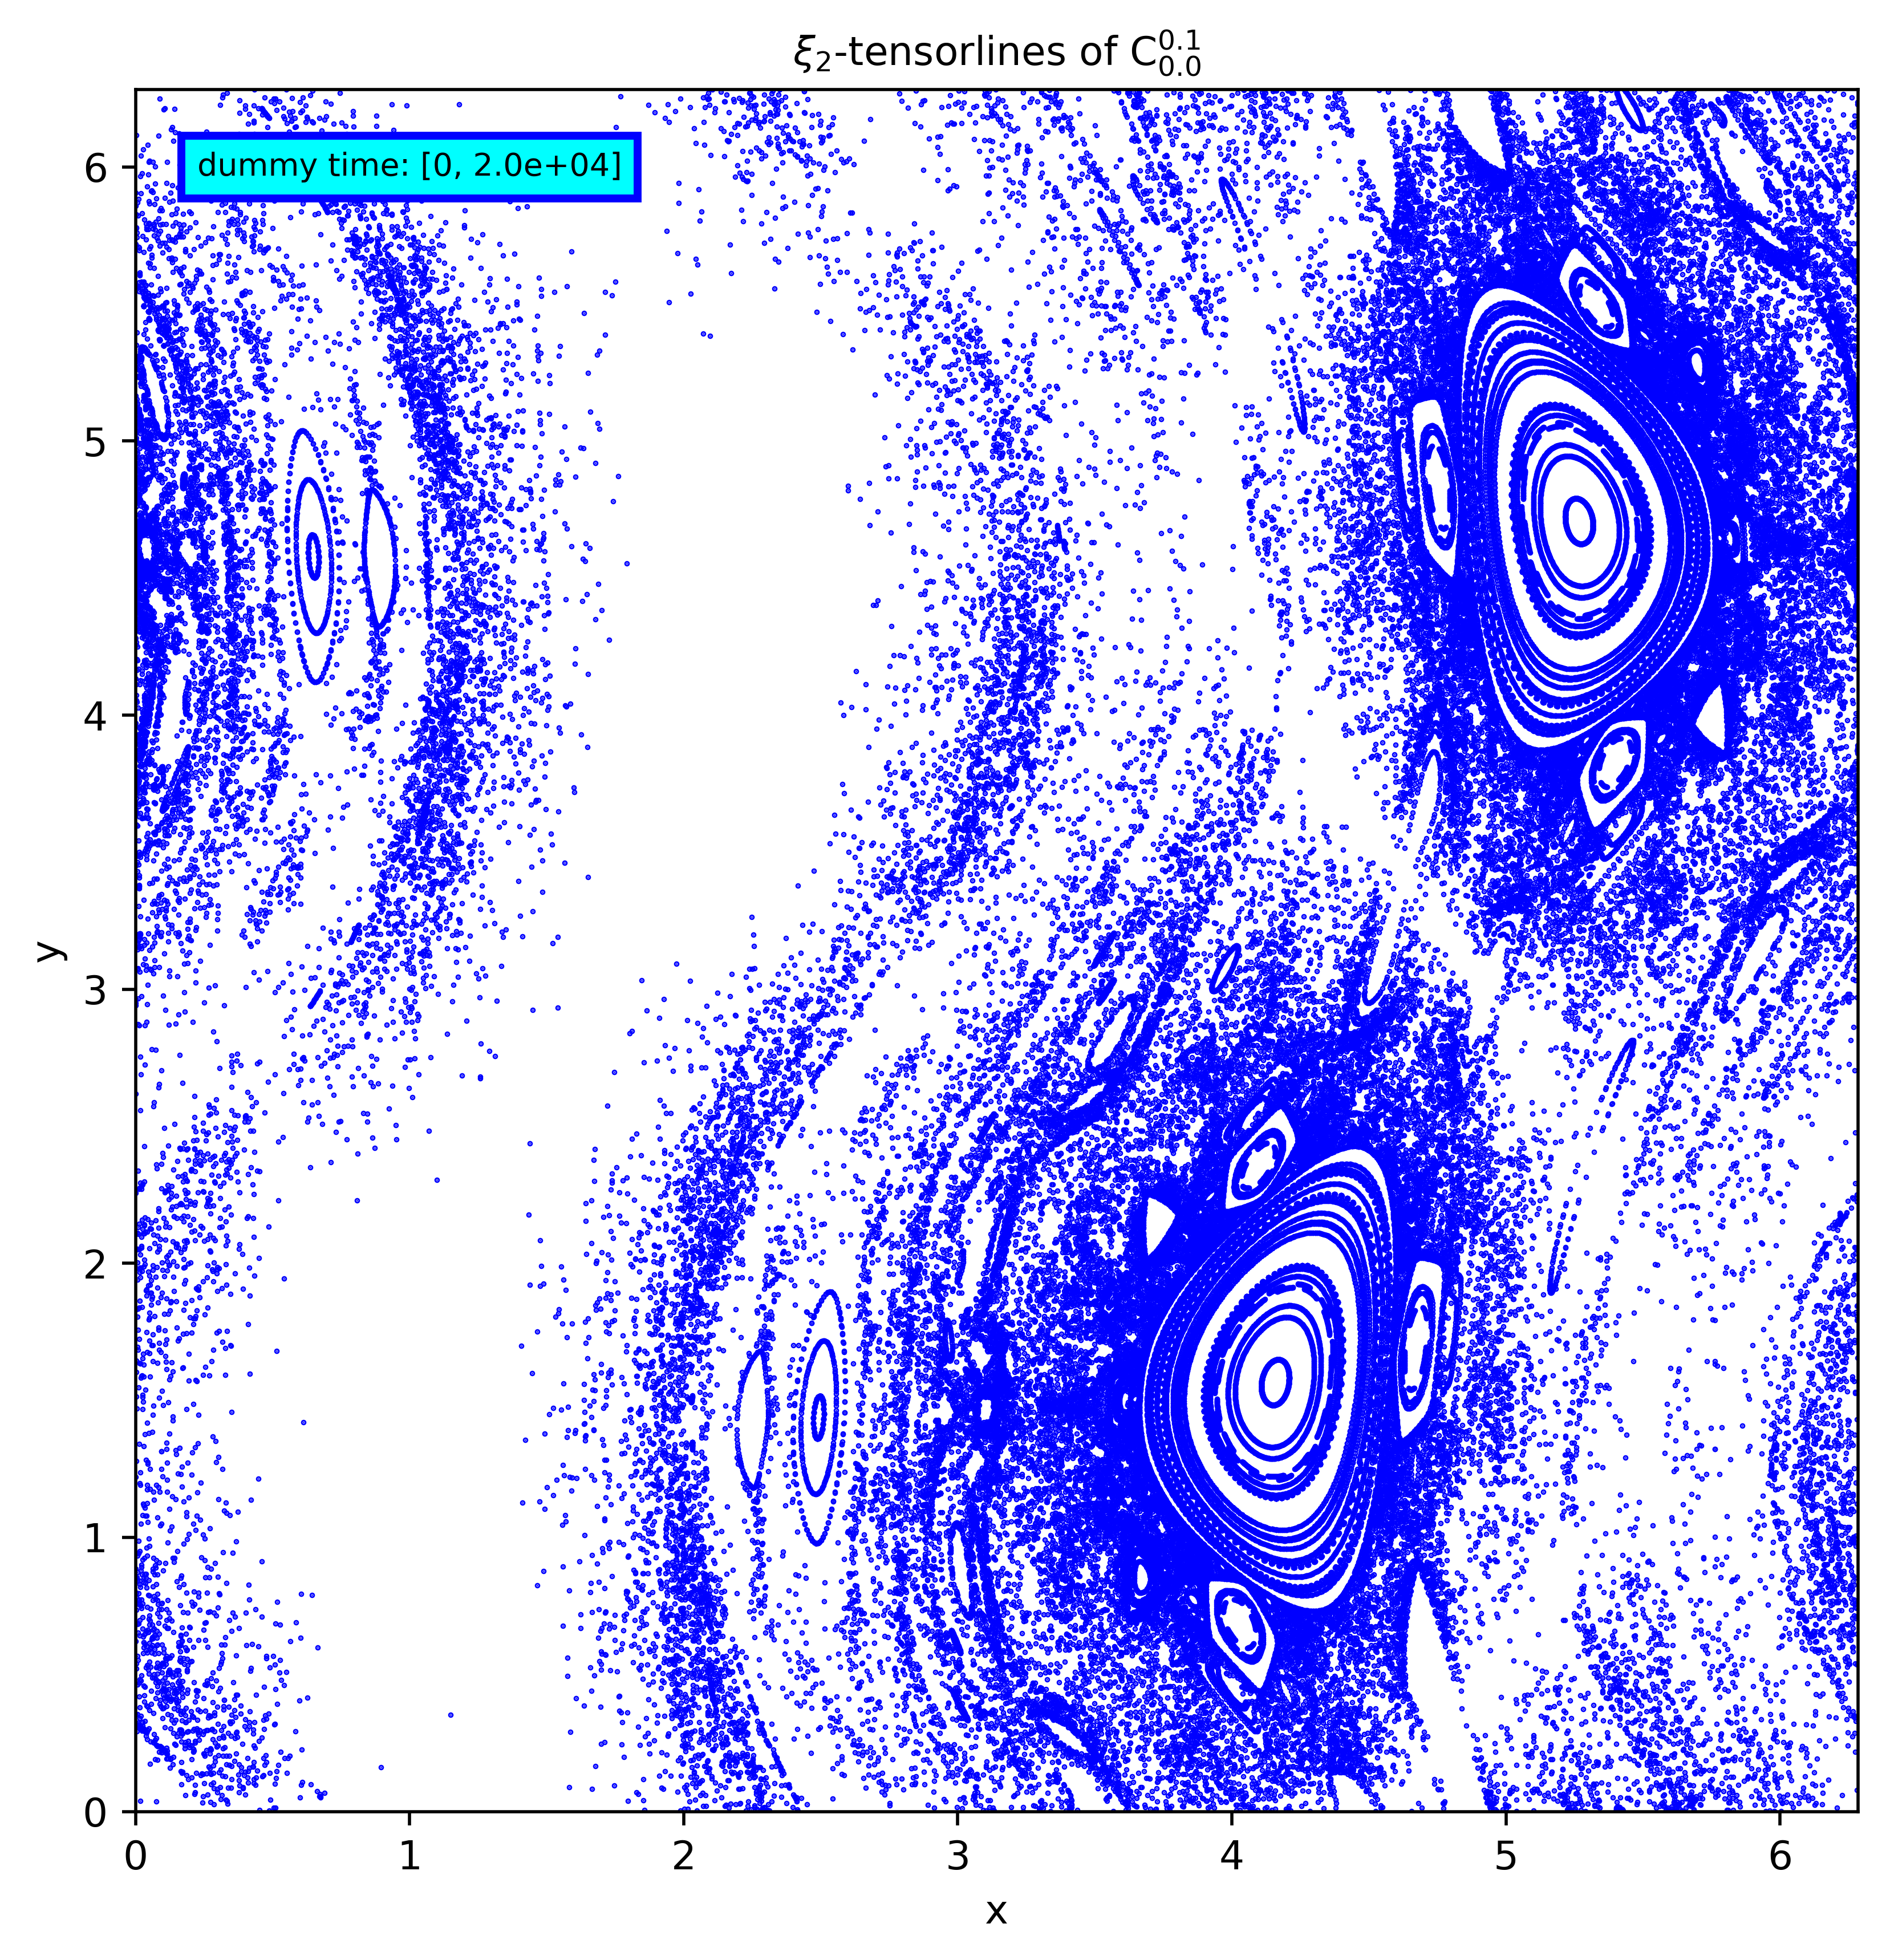

In [13]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize = (8, 8), dpi=500)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = .15, marker = "o")

# Axis Label
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

ax.text(1, 6, f'dummy time: [{int(s_range[0])}, {"{:.1e}".format(np.around(s_range[-1], 0))}]', ha="center", va="center", rotation=0, size=8,
    bbox=dict(fc="cyan", ec="b", lw=2))

# Title
ax.set_title(f'$\u03BE_{2}$'+'-tensorlines of C'+f'$_{{{np.around(time[0],1)}}}^{{{np.around(time[-1],1)}}}$', fontsize = 10)
ax.set_aspect('equal')

plt.savefig("Poincare_"+f'{np.around(z0[0], 2)}'+"_CG_inst.jpg", dpi = 500)

plt.show()